# Rocket Trajectories: Modelling Through Simple ODEs


**Sections:**
1. [Introduction](#id-intro)
2. [Simple Demonstration](#id-simple_demo)
3. [Application 1: The Effect of a Moon on an Orbit](#id-application_1)
4. [Application 2: Monte-Carlo](#id-application_1)
5. [Summary](#id-summary)

---

<div id='id-intro'/>

# Introduction 

With this excersise, we'd like to demonstrate the power of computer modelling/simulations. In this particular example, we purposfully want to abstract from the source code doing all the calculations and focus more on how modelling can be used as a tool to reinforce our understanding of physical systems, and help us parse their most important aspects. 

We've decided upon what should be a relatively familiar example that most humans at least have an intuition for, if not a more rigerous understanding: Newtonian gravity. We're going to imagine that we have a rocket, or satellite, or other random space object flying through some solar system, and we need to know its trajectory. The gravitational force acting on our target object by some other massive body in vector form is,

$$ \vec{F}_{\mathrm{t, \circ}} = \frac{G m_{\mathrm{t}} m_{\circ}}{\vert \vec{r}_{\mathrm{t}} - \vec{r}_{\circ}  \vert^2} \hat{r}_{\mathrm{t, \circ}}. $$

This force depends on the masses of the target and other object, $m_{\mathrm{t}}$ and $m_{\circ}$ respectively, as well as their positions (relative to one another), $\vec{r}_{\mathrm{t}}$, $\vec{r}_{\circ}$, for the satellite and object respectively. $G$ is the gravitational constant, equal to $6.67\times 10^{-11}\ \mathrm{m^3/ kg\ s^2}$. Finally, the direction of this force is described by the unit vector $\hat{r}_{\mathrm{t, \circ}}$ which is given by,

$$ \hat{r}_{\mathrm{t, \circ}} = \frac{\vec{r}_{\mathrm{t}} - \vec{r}_{\circ}}{\vert \vec{r}_{\mathrm{t}} - \vec{r}_{\circ} \vert}. $$

We'll assume for now that the only forces acting on the various objects in our simulation are gravitational, i.e. we ignore solar winds, acceleration from thrusters, etc. Additionally, we will also assume that the various massive objects acting on our target (planets, moons, etc.) do not themselves move! They will remain stationary, so we will just compute how they act on our target affecting its motion through the system. This is an important point, because it means the ordinary differential equation (ODE) descrbing the motion of our target (Newton's second law) should be solveable analytically; the more objects we add to the simulation, the more complicated the arithmatic will be but in principle since the objects themselves don't move the problem can be solved. In a later excersice we will relax this assumption, which will truly show the power of numerical techniques here. The famous "three-body problem" is incredibly difficult to solve but we'll find it takes almost no extra difficulty to numerically simulate even 30 bodies all interacting with each other gravitationally.

Let's start by importing a few packages. The main source code for these simulations is kept in a custom module, `RocketUtils`; this contains functions that compute the gravitational forces, an object wich stores the various attributes of our planetary bodies (mass, position, size, name), and the ODE solvers. We will also import some additional packages for plotting and formatting text, and that's all we need to get started!

In [1]:
push!(LOAD_PATH, ".")  # Append current directory to Julia LOAD_PATH

using RocketUtils
using Plots, LaTeXStrings, Printf

*Note on Units: for simplicity, and performance reasons, all units here are arbitrary. We've tuned $G$ by hand (set as a constant inside `RocketUtils`) so that with a target object's mass of $m_{\mathrm{t}} = 1$, planetary masses on the order of $10^4 \lesssim m_{\circ} \lesssim 10^6$ produce orbits with radii on the order of $\sim 1$. This makes everything easy to visualize and play around with. In principle, this same code could be used to simulate true physical systems just by properly defining $G$ and scaling all the units accordingly, but it would reduce the performance. For the sake of illustration this should suffice.*

<div id='id-simple_demo'/>

## Simple Demonstration

Let's start by just spawning a few objects, some planets and moons. Each of these objects need to have a mass $m_{\circ}$, position $\vec{r}_{\circ}$, a size $s$ wich is just their radius (assuming only spherical bodies), and a name. We will store all of these attributes in a julia `struct` called `Body`, which is defined in the `RocketUtils` package. We siply pass in these attributes as arguments,
```Julia
object_var = Body(mass, position_vector, size, label)
```

We'll place all of these objects in a list, which will be passed into the ODE solver. The solver will then have access to each attribute of theses bodies to compute its effectrs on our target.

Note that at no point can these attributes be changed during simulation; the `Body` struct is *immutable*, meaning once we assign its attributes they cannot be re-assigned without restarting the simulation from the beginning. While it's possible to make *muteable* structs as well, this is fine for us because we're assuming these objects don't move/change for now anyways.

In [2]:
pl_x = Body(1e6, [40.; 40.], 5., "Planet X")
xmn_1 = Body(1e4, [50.; 60.], 1., "X-Moon 1")
xmn_2 = Body(1e4, [30.; 32.], 1.5, "X-Moon 2")
pl_y = Body(1e6, [100.; 80.], 6., "Planet Y")
ymn_1 = Body(1e5, [90.; 90.], 1.5, "Y-Moon 1")

objs = [pl_x ; xmn_1 ; xmn_2 ; pl_y ; ymn_1];  # List of objects

Next well assign a mass, initial position $\vec{r}_0$, and initial velocity $\dot{\vec{r}}_0$ for our target as well.

In [3]:
mass = 1.  # Target mass
r0 = [0. ; 0.]  # Initial position
v0 = [-0. ; 1.3];  # Initial velocity

Now we'll decide on a time for the simulation, $T$. The solver will integrate the gravity ODE over this duration; if at any point our target's position is within the radius of one of our objects though, we've put in a conodition that will stop the solver there, as though there's been a collision!

To solve the ODE we wimply call the solver from `RocketUtils` giving it the various arguments,
```julia
sol = solve_rocket_ODE(target_mass, initial_position, initial_velocity, simulation_time, list_of_objects)
```
This function returns an interpolated solution; we are able to call `sol(t)` for any time $t \in [0, T]$, and it will give use a vector of the positions and velocities of the target at that time! note that the positions/velocities are contained in a single vector, the first several elements being the positions and the last elements being the velocities. This convention has to do with the specifics of the ODE integrator being used.

In [4]:
T = 1000  # Time for simulation

sol = let mass=mass, r0=r0, v0=v0, T=T, objs=objs
    solve_rocket_ODE(mass, r0, v0, T, objs)
end;


Now we can simply plot the solution! We'll also plot the various planets/moons, drawing a circle around them to indicate their size (using the `circle` function written in `RocketUtils`).

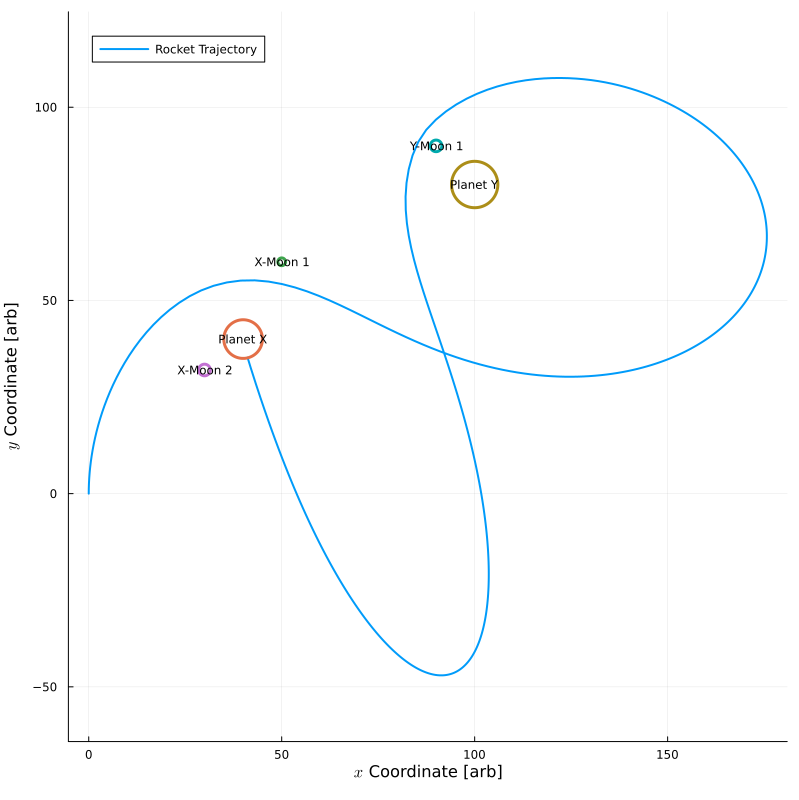

In [5]:
p = plot(;size=(800, 800),
    xlabel=L"x" * " Coordinate [arb]",
    ylabel=L"y" * " Coordinate [arb]",
    aspect_ratio=:equal)
ts = range(0, T; length=1000)

plot!(p, sol(ts)[1,:], sol(ts)[2,:], lw=2, label="Rocket Trajectory")
for ob in objs
    plot!(p, obj_circle(ob), lw=3, label=nothing)
    annotate!(p, ob.r[1], ob.r[2], ob.label, 8)
end

display(p)

<div id='id-application_1'/>

# Application 1: The Effect of a Moon on an Orbit

Let’s apply the code from above to a specific problem now; suppose our target object is in the orbit of a planet. We’ll place a single planet in the middle of our coordinate system, and initialize our target in its orbit.

Further outside of this orbit we’ll also place a moon. We’ll want to see how varying the mass of the moon changes to orbit. To start, we’ll set the mass of the moon to be negligible, $m_{\mathrm{moon}} \rightarrow 0$. This simulation will then act as a control, so we can see how things behave without the moon. Then we’ll perform a series of simulations each with everything the same, except we’ll gradually increase the mass of the moon.

We start by definition the planet struct, and the initial conditions of our target.

In [6]:
mass = 1.  # Target mass
r0 = [10. ; 0.]  # Initial position
v0 = [3. ; 0.]  # Initial velocity

pl_x = Body(1e6, [10.; 10.], 5., "Planet X");

Next we’ll define a list of various moon masses we'd like to simulate. We will then call a `for` loop, which will iterate over these masses. For each moon mass, we will call the ODE solver and save the result.

In [7]:
moon_mass = [0.1 ; 1e2 ; 1e4 ; 1e5]
@assert length(moon_mass) % 2 == 0  # Make sure even number of elements for plotting

moons = [Body(m, [25. ; 15.], 1., "X-Moon") for m in moon_mass]
T = 200  # Time for simulation

sols = [solve_rocket_ODE(mass, r0, v0, T, [pl_x ; mn]) for mn in moons];

Now with all of these trajectories in hand, lets plot the results!

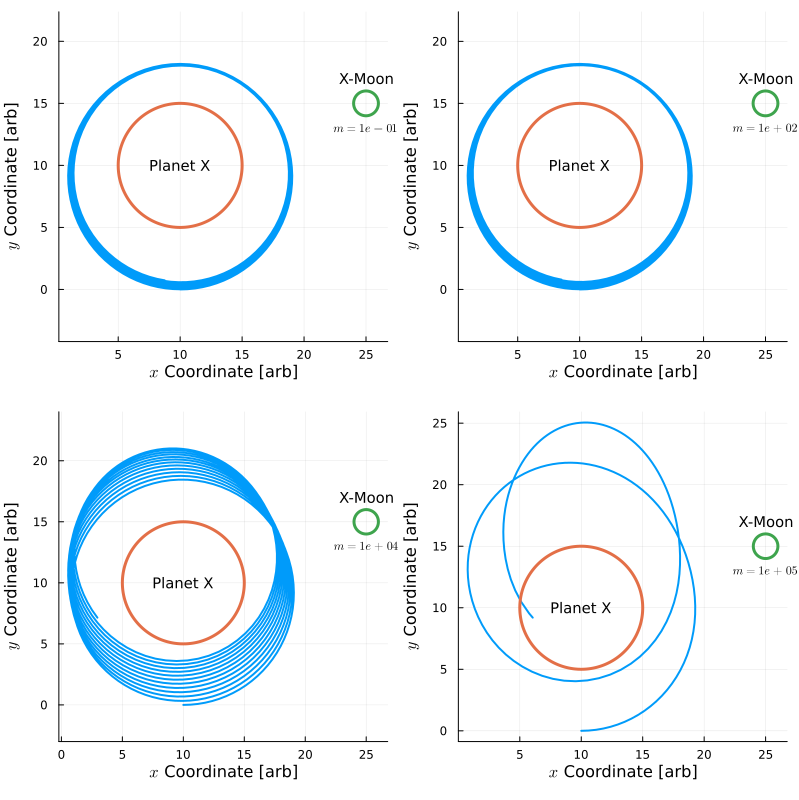

In [8]:
p = plot(;size=(800, 800),
    xlabel=L"x" * " Coordinate [arb]",
    ylabel=L"y" * " Coordinate [arb]",
    aspect_ratio=:equal)
ts = range(0, T; length=1000)  # Time axis


plts = []
for (i, s) in enumerate(sols)
    pl = plot(p, s(ts)[1,:], s(ts)[2,:];
        lw=2,
        label=nothing)
    
    # Objects
    plot!(pl, [obj_circle(ob) for ob in [pl_x ; moons[i]]], lw=3, label=nothing)
    annotate!(pl, pl_x.r[1], pl_x.r[2], pl_x.label, 10)
    annotate!(pl, moons[i].r[1], moons[i].r[2]+2, moons[i].label, 10)
    annotate!(pl, moons[i].r[1], moons[i].r[2]-2, L"m = %$(@sprintf(\"%.0e\", moons[i].m))", 8)

    push!(plts, pl)
end

p_tot = plot(plts...)
display(p_tot)

<div id='id-application_2'/>

# Application 2: Monte-Carlo

Let’s look at another powerful tool: Monte-Carlo simulation. In this technique we will randomly generate a series of inputs, and compute the results. Maybe we’re interested in how varying a particular input, like the initial velocity of our target, effects the result, like the final position of the rocket.

Roughly, this technique involves a relatively brute force way of generating a distribution of outcomes. Rather than doing all of the hard work of computing this distribution manually, we can just try 1,000, or even 1,000,000 different inputs and automatically get the output! This might seem unnecessary in this case, where we could in principle obtain an analytical solution (which is generally much more useful to have), but in many cases this solution may not be known or can’t be calculated. 

Let’s apply this to a particular problem, hinted at above. We’ll assume that we know where our target object is in space, nearby some other objects, but we don’t know *exactly* how fast it’s going. Maybe the onboard instrument which records its velocity has some uncertainty to it. We might ask, how does this uncertainty impact its trajectory? Rather than going through the effort of propagating it by hand, we can just simulate many different velocities within the uncertainty, and collect all of the corresponding outcomes. Then we can do some further analysis on the outcomes.

Let’s start as usual by setting up a few planets and moons in the region where our target will be travelling.

Next, let’s setup our target. We’re gonna assume we know exactly where it is, so we’ll given it a definite initial position, and we know it’s mass as well.

For the initial velocity, however, we’ll assume that it could be any value within a Gaussian (normal) distribution with mean $\mu$ and standard deviation $\sigma$. We could have chosen any other distribution, perhaps specific to our instrument, but for demonstrative purposes a Gaussian will suffice. We will sample many random velocities from this distribution and store them in a list.

Now for each of our initial velocities we’ve sampled let’s run the simulation. We’ll use another `for` loop, just like we in Application 1, to iterate through each velocity saving the result.

Next, let’s plot all of the trajectories. To keep the plot looking more clean, we’ll change the `alpha` value of the curves; this makes the line slightly transparent. It will be easy to see where many lines overlap as a result because lines plotted on top of each other will look darker.

We can also do some analysis on the results to help us quantify the uncertainty in final position. We can take a histogram of the final coordinates, plotting the x- and y-components separately.

<div id='id-summary'/>

# Summary

Here we’ve hopefully demonstrated the usefulness of numerical simulation (modelling) as a tool for understanding physical systems. It shows how easily it can be to throw in different situations and parameters to quickly generate some output which can be useful to us.

This exercise took the simplest possible assumptions, that only the target will move and only through its gravitational interaction with nearby objects. In a later exercise we’ll relax those assumptions, to demonstrate the true power of numerical modelling, where we can add various effects and terms which would ruin our ability to solves things analytically, yet simulate them with the same relative ease as in this demonstration.